# Analysis of results from rapidly-activating rectifier Potassium channel ABC calibration

This notebook compares the behaviour of the $I_\text{Kur}$ current in Nygren, Courtemanche and standardised formulations. Nygren terminology $I_\text{sus}$ is used throughout the notebook.

In [27]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from typing import List

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

import myokit

import pymc3

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

In [28]:
def print_results_table(h: History,
                        modelname: str,
                        h_orig: History=None,
                        round_n: int=4,
                        credible_interval: float=0.89,
                        bootstrap_n: int=10000,
                        original: bool=True):
    round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))    
    round_fn = lambda x: round_to_n(x, round_n)
    
    # load df, w for unified and original (if supplied)
    df, w = h.get_distribution()
    if h_orig is not None:
        df_orig, w_orig = h_orig.get_distribution()
    
    params = []
    if original:
        originals = []
    medians = []
    medians_orig = []
    hpd = []
    hpd_orig = []
    rsd = []
    rsd_orig = []

    m = myokit.load_model(modelname)
    
    # need to bootstrap with weights to calculate weighted mean and HPD
    samples = df.sample(n=bootstrap_n, weights=w, replace=True)
    samples = samples.set_index([pd.Index(range(bootstrap_n))])
    
    samples_orig = pd.DataFrame()
    if h_orig is not None:
        samples_orig = df_orig.sample(n=bootstrap_n, weights=w_orig, replace=True)
        samples_orig = samples_orig.set_index([pd.Index(range(bootstrap_n))])
    
    for name in samples.columns:
        params.append(name.split('.')[1])
        if name.startswith('log_'):
            if original:
                originals.append(m.get(name[4:]).value())
            medians.append((10**(samples[name])).median())
            hpd.append(tuple(pymc3.stats.hpd(10**(samples[name]),
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append((10**(samples_orig[name])).median())
                hpd_orig.append(tuple(pymc3.stats.hpd(10**(samples_orig[name]),
                                                      credible_interval=credible_interval)))
        else:
            if original:
                originals.append(m.get(name).value())
            medians.append(samples[name].median())
            hpd.append(tuple(pymc3.stats.hpd(samples[name],
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append(samples_orig[name].median())
                hpd_orig.append(tuple(pymc3.stats.hpd(samples_orig[name],
                                                      credible_interval=credible_interval)))
    rsd = weighted_cv(df, w, sample_size=len(df))
    if h_orig is not None:
        rsd_orig = weighted_cv(df_orig, w_orig, sample_size=len(df_orig))
        
    for i, hpd_tuple in enumerate(hpd):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd[i] = round_tuple
    for i, hpd_tuple in enumerate(hpd_orig):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd_orig[i] = round_tuple
        
    out_dict = {'Name': params}
    if original:
        out_dict = {**out_dict, 'Published': originals}
    if h_orig is not None:
        out_dict = {**out_dict, 'Median (orig)': medians_orig,
                                'HPD'+str(int(credible_interval*100))+' (orig)': hpd_orig,
                                '$log_{10}$RSD (orig)': rsd_orig}
    out_dict = {**out_dict, 'Median (unif)': medians,
                            'HPD'+str(int(credible_interval*100))+' (unif)': hpd,
                            '$log_{10}$RSD (unif)': rsd}
    out_df = pd.DataFrame(out_dict)
    if original:
        out_df['Published'] = out_df['Published'].map(round_fn)
    out_df['Median (unif)'] = out_df['Median (unif)'].map(round_fn)
    out_df['$log_{10}$RSD (unif)'] = np.log10(out_df['$log_{10}$RSD (unif)']).map(round_fn)
    if h_orig is not None:
        out_df['Median (orig)'] = out_df['Median (orig)'].map(round_fn)
        out_df['$log_{10}$RSD (orig)'] = np.log10(out_df['$log_{10}$RSD (orig)']).map(round_fn)

    print(out_df.to_csv(sep='\t', index=False))

#### Nygren

In [29]:
h_nyg_r_original = History('sqlite:///results/nygren/isus/original/nygren_isus_rgate_original.db')
h_nyg_s_original = History('sqlite:///results/nygren/isus/original/nygren_isus_sgate_original.db')

In [30]:
h_nyg_r_unified = History('sqlite:///results/nygren/isus/unified/nygren_isus_rgate_unified.db')

In [31]:
df_nyg_r_original, w_nyg_r_original = h_nyg_r_original.get_distribution(m=0)
df_nyg_s_original, w_nyg_s_original = h_nyg_s_original.get_distribution(m=0)

In [32]:
df_nyg_r_unified, w_nyg_r_unified = h_nyg_r_unified.get_distribution(m=0)

In [33]:
print_results_table(h_nyg_r_unified, 'models/nygren_isus.mmt',
                    h_orig=h_nyg_r_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	4.3	1.896	(1.821, 1.946)	-1.68	2.031	(1.996, 2.056)	-2.028
p2	8.0	4.541	(4.487, 4.564)	-2.226	4.305	(4.295, 4.324)	-2.61
p4	5.0	-13.6	(-14.21, -13.1)	-1.582	-19.02	(-19.3, -18.77)	-2.056
p5	12.0	7.568	(7.257, 8.027)	-1.496	5.11	(4.962, 5.274)	-1.709
p3	0.009	0.00412	(0.004024, 0.004169)	-2.667	0.0028	(0.002775, 0.002824)	-3.017
p6	0.0005	0.0007859	(0.0007332, 0.0008572)	-2.147	0.0008452	(0.0008232, 0.0008719)	-2.58



In [34]:
print_results_table(h_nyg_s_original, 'models/nygren_isus.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q1	20.0	21.34	(8.065, 51.3)	-0.1842
q2	10.0	12.88	(0.1614, 26.69)	-0.2282
q3	0.6	0.1222	(0.0001271, 0.2662)	-0.1557
q5	60.0	43.52	(-58.23, 98.53)	0.2045
q6	10.0	27.02	(2.015, 45.79)	-0.238
q4	0.047	0.0638	(0.01454, 0.1383)	-0.6109
q7	0.3	0.286	(0.2109, 0.3166)	-0.221



#### Courtemanche

In [35]:
h_cou_a_original = History('sqlite:///results/courtemanche/isus/original/courtemanche_isus_agate_original.db')
h_cou_i_original = History('sqlite:///results/courtemanche/isus/original/courtemanche_isus_igate_original.db')

In [36]:
h_cou_i_unified = History('sqlite:///results/courtemanche/isus/unified/courtemanche_isus_igate_unified.db')

In [37]:
df_cou_a_original, w_cou_a_original = h_cou_a_original.get_distribution(m=0)
df_cou_i_original, w_cou_i_original = h_cou_i_original.get_distribution(m=0)

In [38]:
df_cou_i_unified, w_cou_i_unified = h_cou_i_unified.get_distribution(m=0)

In [39]:
print_results_table(h_cou_a_original, 'models/courtemanche_isus.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	30.3	22.15	(20.03, 24.22)	-1.213
p10	17.0	41.89	(28.79, 49.78)	-0.6841
p2	9.6	17.42	(13.23, 21.33)	-0.8446
p4	10.0	32.09	(-3.277, 87.92)	-0.1005
p5	8.5	16.13	(3.529, 37.86)	-0.2495
p6	-30.0	31.92	(-3.701, 85.69)	-0.1255
p7	59.0	16.26	(1.388, 32.48)	-0.2607
p9	82.0	49.17	(-19.59, 99.54)	0.04513
r2	-15.0	-7.396	(-84.56, 86.28)	1.22
r3	13.0	25.44	(0.0464, 43.73)	-0.231
p3	0.65	0.04514	(0.00102, 0.1093)	-0.4886
p8	2.5	0.06683	(0.001001, 0.5136)	-0.1877
r1	10.0	9.004	(1.009, 61.18)	-0.2278



In [40]:
print_results_table(h_cou_i_unified, 'models/courtemanche_isus.mmt',
                    h_orig=h_cou_i_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q1	-99.45	-67.37	(-143.5, -1.417)	-0.1766	54.84	(54.83, 54.85)	-3.809
q2	27.48	34.46	(15.89, 49.79)	-0.4477	39.95	(39.95, 39.96)	-3.968
q4	-185.0	-121.1	(-198.9, -32.4)	-0.2815	74.2	(72.4, 81.08)	-1.373
q5	28.0	26.75	(0.6525, 43.83)	-0.2649	3.695	(2.086, 4.116)	-0.6464
q6	-158.0	-172.0	(-199.9, -134.3)	-0.8272	-150.6	(-197.1, -93.12)	-0.6078
q7	16.0	23.63	(15.01, 29.02)	-0.5748	1.986	(0.003291, 4.561)	-0.1569
q3	21.0	1949.0	(0.1185, 5858.0)	-0.319	674.0	(674.0, 674.0)	-5.458



#### Standardised

In [41]:
h_sta = History('sqlite:///results/standardised/isus/standardised_isus.db')

In [42]:
df_sta, w_sta = h_sta.get_distribution(m=0)

In [43]:
print_results_table(h_sta, 'models/standardised_isus.mmt', original=False)

Name	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p_2	0.1458	(0.1284, 0.1683)	-1.043
p_4	0.02021	(0.01903, 0.02214)	-1.306
p_6	0.00156	(0.001216, 0.001859)	-0.8671
p_8	0.02782	(0.02364, 0.03106)	-1.079
p_1	0.05576	(0.0432, 0.06453)	-1.367
p_3	0.1188	(0.1097, 0.1279)	-1.634
p_5	0.004436	(0.004299, 0.004555)	-2.485
p_7	1.418e-07	(1.003e-07, 3.607e-07)	-1.417



## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.## Compare number of parameters

In [18]:
data = [['N',6,7],['C',13,7],['S',4,4]]

In [19]:
df = pd.DataFrame(data, columns = ['model', 'act', 'inact'])

In [20]:
df.inact = df.act+df.inact

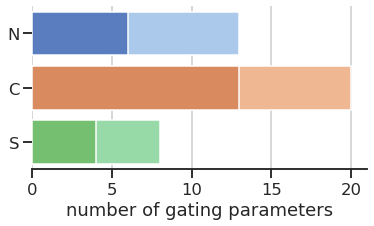

In [21]:
sns.set(style="ticks")
sns.set_context('talk')
sns.set_color_codes("pastel")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=df,
            palette="pastel", dodge=False)
            #label="inact", color="b")

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=df,
            palette="muted", dodge=False)
            #label="act", color="r")

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(left=True)

In [23]:
#f.savefig('figures/isus/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [24]:
rsd_nyg_r_original = weighted_cv(df_nyg_r_original, w_nyg_r_original, sample_size=len(df_nyg_r_original))
rsd_nyg_s_original = weighted_cv(df_nyg_s_original, w_nyg_s_original, sample_size=len(df_nyg_s_original))

rsd_nyg_original = pd.concat([rsd_nyg_r_original, rsd_nyg_s_original])
model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [25]:
rsd_nyg_r_unified = weighted_cv(df_nyg_r_unified, w_nyg_r_unified, sample_size=len(df_nyg_r_unified))

rsd_nyg_unified = pd.concat([rsd_nyg_r_unified, rsd_nyg_s_original])
model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [26]:
rsd_cou_a_original = weighted_cv(df_cou_a_original, w_cou_a_original, sample_size=len(df_cou_a_original))
rsd_cou_i_original = weighted_cv(df_cou_i_original, w_cou_i_original, sample_size=len(df_cou_i_original))

rsd_cou_original = pd.concat([rsd_cou_a_original, rsd_cou_i_original])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [27]:
rsd_cou_i_unified = weighted_cv(df_cou_i_unified, w_cou_i_unified, sample_size=len(df_cou_i_unified))

rsd_cou_unified = pd.concat([rsd_cou_a_original, rsd_cou_i_unified])
model = ['C',]*len(rsd_cou_unified)
data = ['UNIFIED',]*len(rsd_cou_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_unified}
cou_unified = pd.DataFrame(frame)

In [28]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified], sort=False)

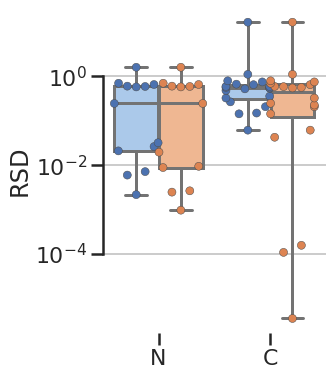

In [29]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [31]:
#f.savefig('figures/isus/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [32]:
N = 100

In [33]:
nyg_par_samples_r_original = df_nyg_r_original.sample(n=N, weights=w_nyg_r_original, replace=True)
nyg_par_samples_r_original = nyg_par_samples_r_original.set_index([pd.Index(range(N))])
nyg_par_samples_s_original = df_nyg_s_original.sample(n=N, weights=w_nyg_s_original, replace=True)
nyg_par_samples_s_original = nyg_par_samples_s_original.set_index([pd.Index(range(N))])

nyg_par_samples_original = (pd.concat([nyg_par_samples_r_original, 
                                       nyg_par_samples_s_original],axis=1)
                            .to_dict(orient='records'))

In [34]:
nyg_par_samples_r_unified = df_nyg_r_unified.sample(n=N, weights=w_nyg_r_unified, replace=True)
nyg_par_samples_r_unified = nyg_par_samples_r_unified.set_index([pd.Index(range(N))])

nyg_par_samples_unified = (pd.concat([nyg_par_samples_r_unified, 
                                      nyg_par_samples_s_original],axis=1)
                           .to_dict(orient='records'))

In [35]:
v = np.arange(-100, 50, 0.5)

nyg_par_map = {'ri': 'isus.r_inf',
               'rt': 'isus.tau_r',
               'si': 'isus.s_inf',
               'st': 'isus.tau_s'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


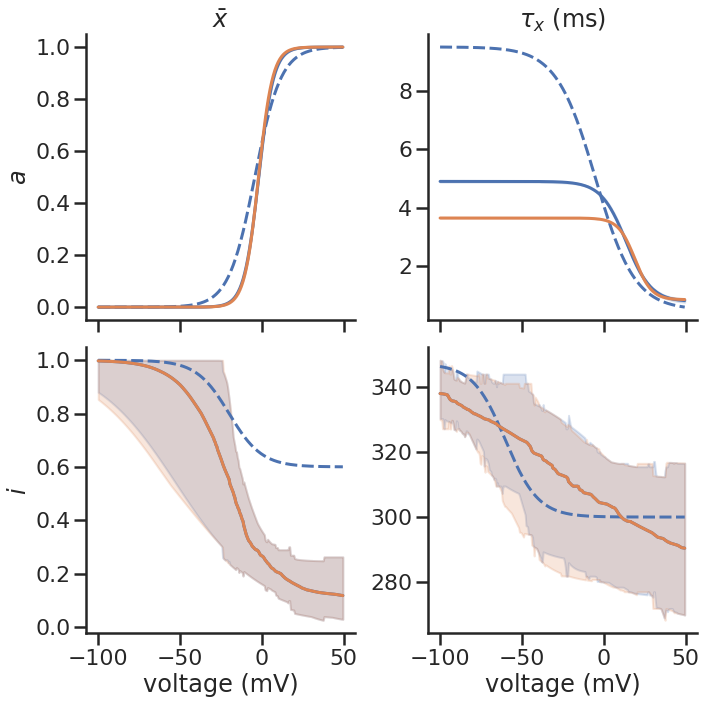

In [36]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
sns.set_palette('deep')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, nyg_par_map], 
                       ['models/nygren_isus.mmt', 'models/nygren_isus_.mmt'], 
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$a$')
ax[1][0].set_ylabel(r'$i$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

#for a in ax[:,0]:
#    a.set_ylim((-0.05, 1.05))
    
plt.tight_layout()

In [38]:
#f.savefig('figures/isus/nyg_gating_functions.pdf')

In [39]:
cou_par_samples_a_original = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(N))])
cou_par_samples_i_original = df_cou_i_original.sample(n=N, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(N))])

cou_par_samples_original = pd.concat([cou_par_samples_a_original, cou_par_samples_i_original],axis=1).to_dict(orient='records')

In [40]:
cou_par_samples_i = df_cou_i_unified.sample(n=N, weights=w_cou_i_unified, replace=True)
cou_par_samples_i = cou_par_samples_i.set_index([pd.Index(range(N))])
cou_par_samples_unified = pd.concat([cou_par_samples_a_original, cou_par_samples_i],axis=1).to_dict(orient='records')

In [41]:
cou_par_map = {'ri': 'isus.a_inf',
               'rt': 'isus.tau_a',
               'si': 'isus.i_inf',
               'st': 'isus.tau_i'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


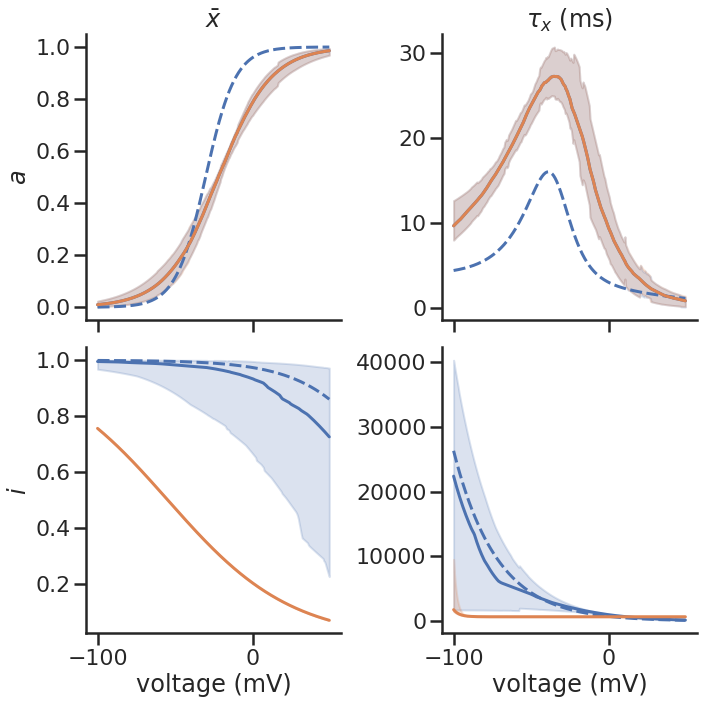

In [42]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
sns.set_palette('deep')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [cou_par_map, cou_par_map], 
                       ['models/courtemanche_isus.mmt', 'models/courtemanche_isus_.mmt'], 
                       [cou_par_samples_original, cou_par_samples_unified],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$a$')
ax[1][0].set_ylabel(r'$i$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

#for a in ax[:,0]:
#    a.set_ylim((-0.05, 1.05))

#ax[1,1].set_ylim((-0.05*25000, 1.05*25000))
    
plt.tight_layout()

In [44]:
#f.savefig('figures/isus/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [45]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [46]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

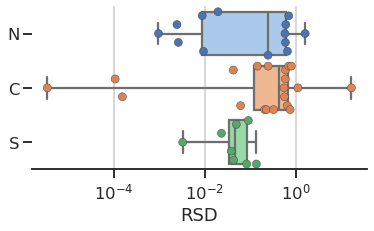

In [47]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(left=True)

In [49]:
#f.savefig('figures/isus/rsd_compare_unified.pdf')

In [50]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=45.0, pvalue=0.31891519499830134)

In [51]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=32.0, pvalue=0.00785462752352008)

In [52]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=115.0, pvalue=0.2965894121668926)

### Residuals to experimental data

In [53]:
N = 100

In [54]:
eps_nyg_r = h_nyg_r_unified.get_weighted_distances()
eps_nyg_s = h_nyg_s_original.get_weighted_distances()

In [55]:
eps_nyg = np.array([])
eps_nyg = (np.array(eps_nyg_r.sample(n=100,axis=0,weights=eps_nyg_r.w,replace=True).distance) +
           np.array(eps_nyg_s.sample(n=100,axis=0,weights=eps_nyg_s.w,replace=True).distance))
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [56]:
eps_cou_a = h_cou_a_original.get_weighted_distances()
eps_cou_i = h_cou_i_unified.get_weighted_distances()
eps_cou = np.array([])
eps_cou = (np.array(eps_cou_a.sample(n=100,axis=0,weights=eps_cou_a.w,replace=True).distance) +
           np.array(eps_cou_i.sample(n=100,axis=0,weights=eps_cou_i.w,replace=True).distance))
eps_cou = pd.DataFrame({'model': 'C', 'eps': eps_cou, 'exp': 'all'})

In [57]:
eps_sta = h_sta.get_weighted_distances()
eps_sta = eps_sta.sample(n=100,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [58]:
eps = pd.concat([eps_nyg,eps_cou,eps_sta])

In [59]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'normalised residual')

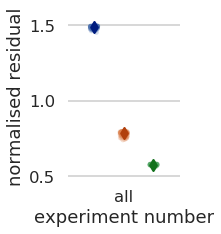

In [60]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [62]:
#f.savefig('figures/isus/eps_all_stripplot.pdf')

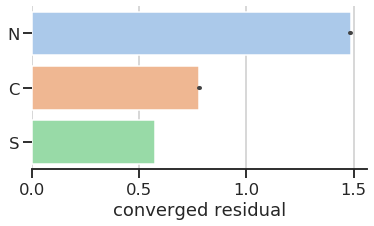

In [63]:
sns.set_context('talk')
sns.set_style("ticks")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="converged residual")
sns.despine(left=True)

In [65]:
#f.savefig('figures/isus/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [66]:
N = 100

nyg_par_samples_r = df_nyg_r_unified.sample(n=N, weights=w_nyg_r_unified, replace=True)
nyg_par_samples_r = nyg_par_samples_r.set_index([pd.Index(range(N))])
nyg_par_samples_r = nyg_par_samples_r.to_dict(orient='records')
nyg_par_samples_s = df_nyg_s_original.sample(n=N, weights=w_nyg_s_original, replace=True)
nyg_par_samples_s = nyg_par_samples_s.set_index([pd.Index(range(N))])
nyg_par_samples_s = nyg_par_samples_s.to_dict(orient='records')

cou_par_samples_a = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a = cou_par_samples_a.set_index([pd.Index(range(N))])
cou_par_samples_a = cou_par_samples_a.to_dict(orient='records')
cou_par_samples_i = df_cou_i_unified.sample(n=N, weights=w_cou_i_unified, replace=True)
cou_par_samples_i = cou_par_samples_i.set_index([pd.Index(range(N))])
cou_par_samples_i = cou_par_samples_i.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [67]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

In [68]:
from experiments.isus_wang import (wang_act,
                                   wang_act_kin,
                                   wang_inact)
from experiments.isus_courtemanche import (courtemanche_inact_kin,
                                           courtemanche_deact)
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

experiments = [wang_act,
               wang_act_kin,
               courtemanche_deact,
               firek_inact,
               nygren_inact_kin,
               nygren_rec]
models = ['models/nygren_isus_temp_adj.mmt',
          'models/courtemanche_isus_temp_adj.mmt',
          'models/standardised_isus.mmt']
par_samples = [[nyg_par_samples_r,nyg_par_samples_s], [cou_par_samples_a,cou_par_samples_i], std_par_samples]
names = ['N','C','S']

In [69]:
def experiment_dist(par_samples, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in par_samples:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

__The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.__

In [70]:
df = pd.DataFrame({})
mask = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1], None]
for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(par_samples[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(par_samples[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

Text(0, 0.5, 'normalised residual')

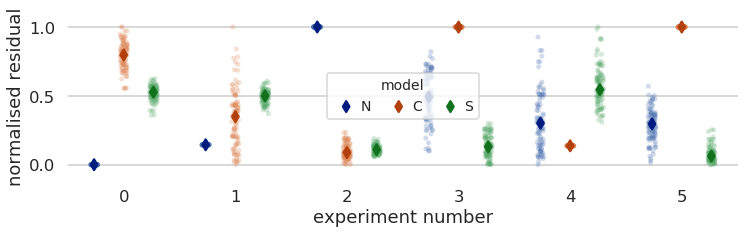

In [71]:
sns.set_context('talk')
sns.set_style('whitegrid')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize=(12, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
            dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [73]:
#fig.savefig('figures/isus/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [44]:
from experiments.isus_wang import (wang_act_and_kin,
                                   wang_inact)
from experiments.isus_courtemanche import (courtemanche_inact_kin,
                                           courtemanche_deact)
from experiments.isus_firek import (firek_inact)
from experiments.isus_nygren import (nygren_inact_kin,
                                     nygren_rec)

In [45]:
from ionchannelABC.visualization import plot_data_adjustment

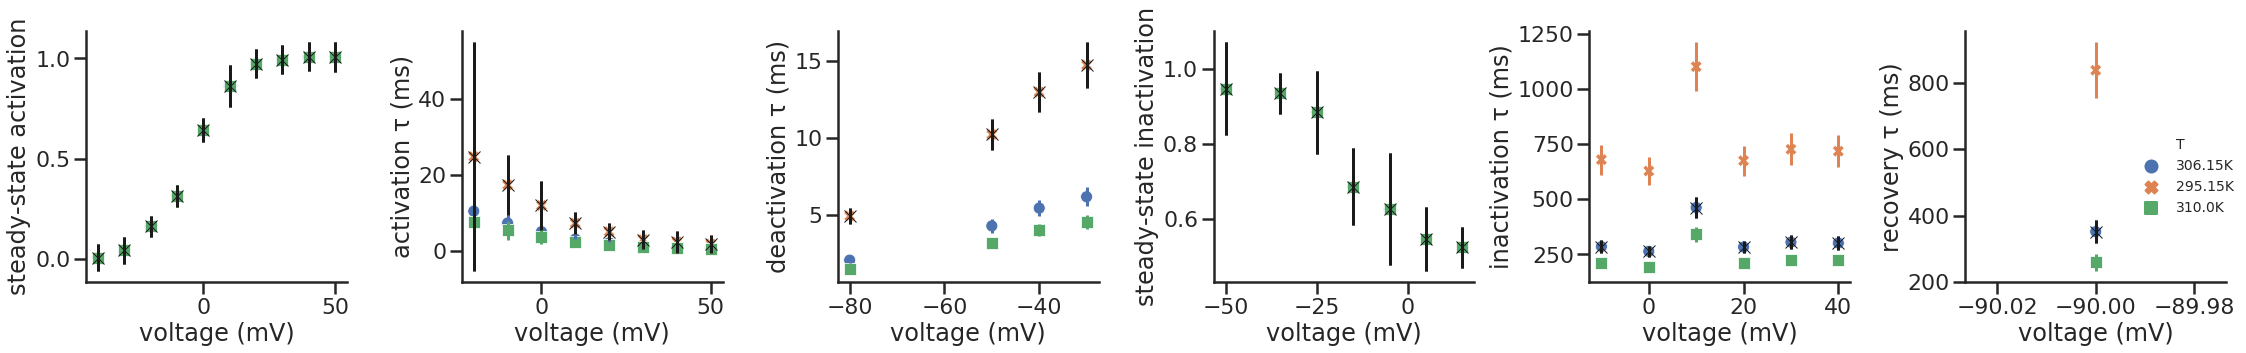

In [76]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_data_adjustment(['models/nygren_isus.mmt','models/courtemanche_isus.mmt','models/standardised_isus.mmt'],
                         wang_act_and_kin,
                         courtemanche_deact,
                         firek_inact,
                         nygren_inact_kin,
                         nygren_rec)

ylabels = ["steady-state activation", "activation τ (ms)", "deactivation τ (ms)", "steady-state inactivation",
           "inactivation τ (ms)", "recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [78]:
#g.savefig('ikur_data_adjustment.pdf')

In [46]:
from ionchannelABC.visualization import plot_sim_results

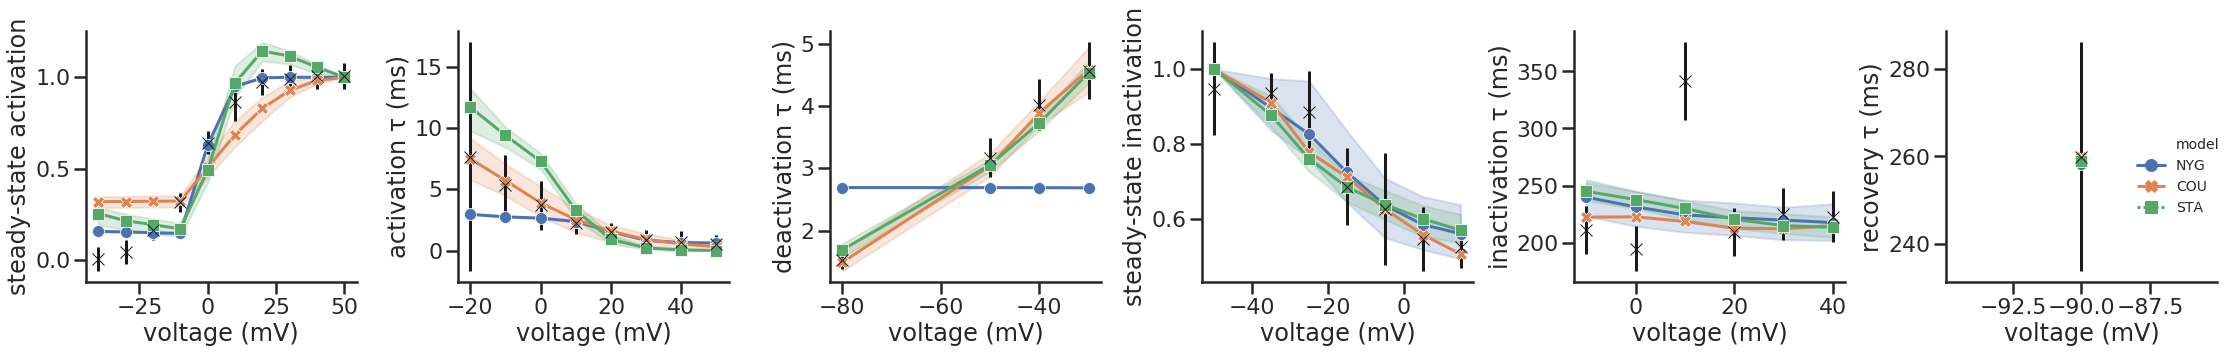

In [47]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_isus.mmt',
                      'models/nygren_isus.mmt',
                      'models/courtemanche_isus.mmt',
                      'models/courtemanche_isus.mmt',
                      'models/standardised_isus.mmt'],
                     wang_act_and_kin,
                    courtemanche_deact,
                    firek_inact,
                    nygren_inact_kin,
                    nygren_rec,
                     temp_match_model = 4,
                     masks=[[(0,1),2]+[None,]*3,
                            [None,]*2+[3,4,5],
                            [(0,1),2]+[None,]*3,
                            [None,]*2+[3,4,5],
                            None],
                     df=[df_nyg_r_unified,
                         df_nyg_s_original,
                         df_cou_a_original,
                         df_cou_i_unified,
                         df_sta], 
                     w=[w_nyg_r_unified,
                        w_nyg_s_original,
                        w_cou_a_original,
                        w_cou_i_unified,
                        w_sta])

ylabels = ["steady-state activation", "activation τ (ms)", "deactivation τ (ms)", "steady-state inactivation",
           "inactivation τ (ms)", "recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [49]:
#g.savefig('figures/isus/compare_summary_statistics.pdf')

### Compare SS and tau values

In [18]:
nyg = 'models/nygren_isus_temp_adj.mmt'
cou ='models/courtemanche_isus_temp_adj.mmt'
std = 'models/standardised_isus.mmt'

In [19]:
v = np.arange(-80, 50, 0.5)

In [23]:
nyg_par_map = {'ri': 'isus.r_inf',
               'si': 'isus.s_inf',
               'rt': 'isus.tau_r',
               'st': 'isus.tau_s'}

cou_par_map = {'ri': 'isus.a_inf',
               'si': 'isus.i_inf',
               'rt': 'isus.tau_a',
               'st': 'isus.tau_i'}

std_par_map = {'ri': 'isus.r_ss',
               'si': 'isus.s_ss',
               'rt': 'isus.tau_r',
               'st': 'isus.tau_s'}

In [24]:
N = 100

nyg_par_samples_r = df_nyg_r_unified.sample(n=N, weights=w_nyg_r_unified, replace=True)
nyg_par_samples_r = nyg_par_samples_r.set_index([pd.Index(range(N))])
nyg_par_samples_s = df_nyg_s_original.sample(n=N, weights=w_nyg_s_original, replace=True)
nyg_par_samples_s = nyg_par_samples_s.set_index([pd.Index(range(N))])
nyg_par_samples = (pd.concat([nyg_par_samples_r,
                              nyg_par_samples_s],axis=1).to_dict(orient='records'))

cou_par_samples_a = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a = cou_par_samples_a.set_index([pd.Index(range(N))])
cou_par_samples_i = df_cou_i_unified.sample(n=N, weights=w_cou_i_unified, replace=True)
cou_par_samples_i = cou_par_samples_i.set_index([pd.Index(range(N))])
cou_par_samples = pd.concat([cou_par_samples_a,cou_par_samples_i],axis=1).to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

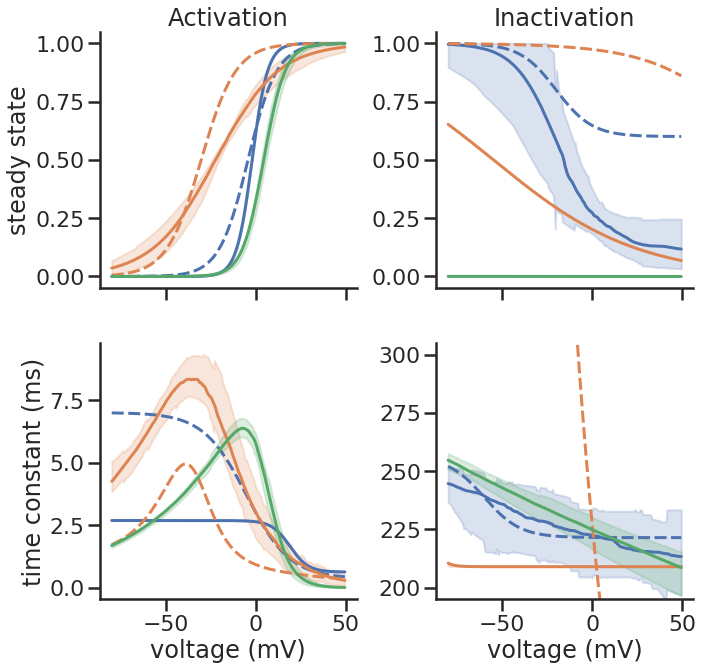

In [25]:
sns.set(style='ticks')
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(2,2))

ax[0][0].set_ylabel('steady state')
ax[1][0].set_ylabel('time constant (ms)')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Inactivation')

for a in ax[0,:]:
    a.set_ylim((-0.05, 1.05))

for a in ax[:,1:].flatten():
    a.set_ylabel('')
    
for a in ax[1,:]:
    a.set_xlabel('voltage (mV)')
    
ax[1][1].set_ylim([-0.05*100+200, 1.05*100+200])
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [26]:
#f.savefig('figures/isus/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [90]:
import myokit

In [91]:
nsteps = 100
period = 10000
tstep = 1000
vhold = -50
vstep = -10

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [92]:
# nygren_ina_full has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_isus_temp_adj.mmt',
                                                         'models/courtemanche_isus_temp_adj.mmt',
                                                         'models/standardised_isus.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [93]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [94]:
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [95]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['isus.g','engine.time','membrane.V'],
                        log_interval=1)
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['isus.g']/max(datalog['isus.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['isus.g','engine.time','membrane.V'],
                        log_interval=1)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['isus.g']/max(datalog['isus.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [96]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

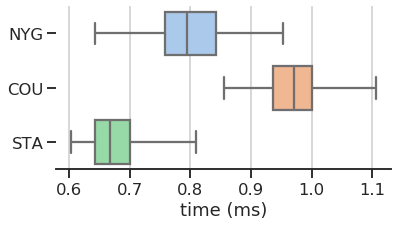

In [97]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [99]:
#f.savefig('figures/isus/runtime_compare.pdf')

In [100]:
all_samples_detail = all_samples[(all_samples['time']>=19) & (all_samples['time'] < 50)]

Text(0.5, 1.0, '')

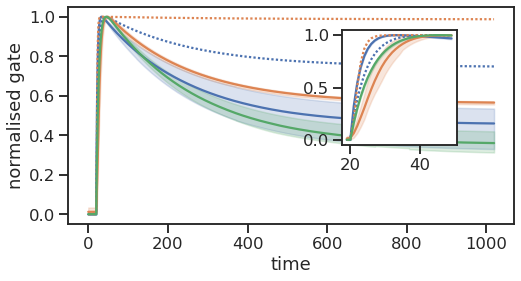

In [101]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 estimator=np.median,
                 ci=None,
                 legend=False)

# plot 89% HDPI
for mi, m in enumerate(all_samples['model'].unique()):
    data = all_samples[(all_samples['model']==m) & \
                       (all_samples['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                    alpha=0.2, color=sns.color_palette()[mi])

ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             estimator=np.median,
             ci=None,
             legend=False)
# plot 89% HDPI
for mi, m in enumerate(all_samples_detail['model'].unique()):
    data = all_samples_detail[(all_samples_detail['model']==m) & \
                              (all_samples_detail['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax2.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                     alpha=0.2, color=sns.color_palette()[mi])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [103]:
#f.savefig('figures/isus/trace_compare.pdf')